# Higgs significance exercise

## 1. $H\to\gamma\gamma$ invariant mass spectrum toy simulation

We begin by defining a function that generetase pseudo-data, returning an histogram mimicking the observed diphoton invariant mass spectrum for a given luminosity. The function assumes an exponential functional form for the continuous background cross section:

$$\frac{d\sigma_B}{d m_{\gamma\gamma}} = C e^{-b m_{\gamma\gamma}}$$

with $C \simeq 1145\,\text{fb/GeV}$ and $b \simeq 0.023 \,\text{GeV}^{-1}$. These parameter are hardcoded in the function, but you can experiment to change them. 

The Higgs effective cross section is assumed to be:

$$\sigma_S(m_H = 125 \text{GeV}) \cdot BR \cdot \varepsilon \simeq 10 \text{fb}$$

The $H\to\gamma\gamma$ peak is described by a Gaussian centered at $m_H$, with a width $\sigma_{\gamma\gamma}$ dominated by the detector diphoton invariant mass resolution. The shape parameter for the Higgs peak are given as parameters to the function. 

The number of signal and background events for a given integrated luminosity are computed as results of Poisson discribution starting from the expected average number of events, obtained from the respective cross-sections:

$$\langle N_{S,B} \rangle = \mathcal{L} \cdot \sigma_{S,B}$$

$$N_{S,B} = \text{Poisson}(\langle N_{S,B} \rangle)$$

In [1]:
import ROOT
import math

Welcome to JupyROOT 6.14/06


In [2]:
def DataHistogram(m_higgs,sigma_m,lumi,
                  mMin = 100.,
                  mMax = 150.,
                  nCha = 50):
    """
    Function to generate a random (pseudo) diphoton invariant-mass spectrum
    Returns a TH1F
    """
    h_mgg = ROOT.TH1F("h_mgg","",nCha,mMin,mMax)

    # background cross section
    # dsigma/dm_gammagamma = 1145. fb/GeV exp(-0.023 GeV-1 * m_gammagamma)
    background = ROOT.TF1("background","1145.*exp(-0.023*x)",mMin,mMax)

    # total background cross section
    sigma_bck = background.Integral(mMin,mMax)

    # Higgs cross section x BR x detector efficiency ~ 10 fb 
    # Gaussian around Higgs mass, with width dependent on gamma-gamma invariant mass resolution
    higgs = ROOT.TF1("higgs","10.*exp(-0.5*(x-[0])^2/[1]^2)/(sqrt(6.28)*[1])",mMin,mMax)
    higgs.SetParameter(0,m_higgs) # Higgs mass 
    higgs.SetParameter(1,sigma_m) # invariant mass width

    # total higgs cross section
    sigma_higgs=higgs.Integral(mMin,mMax);

    # Random number generator
    generator = ROOT.TRandom(0)

    # Higgs spectrum generation
    # Number of events is given by Poisson distribution around expected value
    # Invariant mass spectrum is obtained from differential cross section
    nHiggs = generator.Poisson(lumi*sigma_higgs)
    for i in range(nHiggs):
        h_mgg.Fill(higgs.GetRandom())

    # Background spectrum generation
    # Number of events is given by Poisson distribution around expected value
    # Invariant mass spectrum is obtained from differential cross section
    nBck = generator.Poisson(lumi*sigma_bck)
    for i in range(nBck):
        h_mgg.Fill(background.GetRandom())

    h_mgg.GetXaxis().SetTitle("m_{#gamma#gamma} [GeV]")
    h_mgg.GetYaxis().SetTitle("Events / 1 GeV")
    return h_mgg

### Let's generate some pseudo-data and have a look at it

Try to change the parameters for the luminosity and see how the spectrum shape change with more or less data...

Can you see the Higgs peak by eye?

In [3]:
L   = 30.  # integrated luminosity fb-1
m_H = 125. # GeV
s_m = 1.4  # GeV

mgg = DataHistogram(m_H,s_m,L)

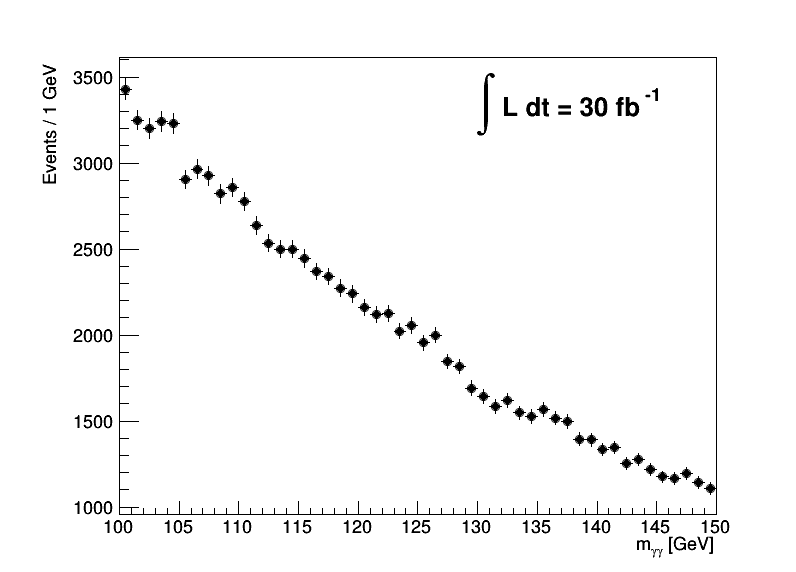

In [4]:
c = ROOT.TCanvas("c","",50,50,800,600);
c.cd(1).SetLeftMargin(0.15)

mgg.SetStats(0)
mgg.SetMarkerStyle(20)
mgg.SetLineColor(1)
mgg.Draw("E")

label = ROOT.TLatex()
label.SetTextSize(0.05)
label.SetTextAlign(12)
label.DrawLatexNDC(0.6,0.8,"#int L dt = "+str(int(L))+" fb^{-1}")
                   
c.Draw()

## 2. Diphoton invariant mass fit

We want to fit out generated pseudo-data with a function with two component to extract the number of signal events from the spectrum. This emulates (in a simplified way!) what the LHC experiments do to look for a $H\to\gamma\gamma$ signal. We will use a function defined as the sum of an exponentian and a Gaussian components:

$$ \frac{dN}{d m_{\gamma\gamma}} = p_0 e^{-p1 m{_\gamma\gamma}} + p_2 \frac{1}{\sqrt{2 \pi p_4}} 
e^{ -\frac{(m_{\gamma\gamma} - p_3)^2}{p_4^2}}$$

The parameter $p_0$ measures the observed total number of background events $N_B^{\text{obs}}$, the parameter $p_0$ the observed number of signal events $N_S^{\text{obs}}$.

In [5]:
def massSB(x,p):
    """
    Function to perfom a simple S+B fit to the gamma-gamma invariant mass spectrum
    Signal: gaussian
    background: exponential
    x[0] = Invariant mass
    p[0],p[1] = Background  p[0]*exp(-p[1]*m_gammagamma)
    p[2] = Gaussian normalisation
    p[3] = Higgs mass
    p[4] = Mass resolution
    """
    b = p[0]*math.exp(-p[1]*x[0])
    s = p[2]*(1./(math.sqrt(2.*math.pi*p[4]))*math.exp(-0.5*(x[0]-p[3])*(x[0]-p[3])/(p[4]*p[4])))
    return b+s

massFit = ROOT.TF1('massFit',massSB,100.,200.,5)

 FCN=49.1193 FROM MIGRAD    STATUS=CONVERGED     211 CALLS         212 TOTAL
                     EDM=1.13894e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.50942e+04   9.57594e+02   3.83721e+00  -4.15956e-06
   2  p1           2.31760e-02   2.26375e-04   8.31952e-07   1.86750e+01
   3  p2           2.80223e+02   8.86259e+01   9.34240e-05  -1.58978e-02
   4  p3           1.25600e+02   6.89227e-01   4.50513e-04   4.69273e-03
   5  p4           1.40000e+00     fixed    


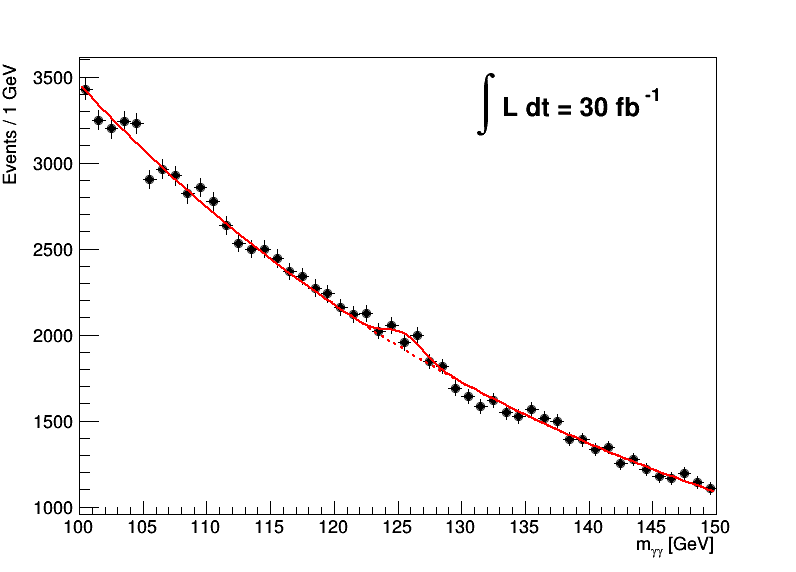

In [6]:
# Now let's fit the histogram. 
# Lets' start by setting the initial values for the fit parameters 

massFit.SetParameter(0,1.E+5) # Background
massFit.SetParameter(1,0.023); # Background
massFit.SetParameter(2,500.);  # Gaussian normalization
massFit.SetParameter(3,m_H);   # Higgs mass
massFit.SetParameter(4,s_m);   # Diphoton mass resolution
 
#     Especially at low statistics, sometimes is can happen than mass
#     measured value diverges or that Higgs signal fraction converge
#     toward un-physical limits. We might then need to impose a range
#     for these parameters.

massFit.SetParLimits(2,0.,1.E+5)
massFit.SetParLimits(3,m_H-10.,m_H+10.)
massFit.SetParLimits(4,s_m*0.5,s_m*2.)

# Mass resolution should come from independent measurement! Why? 
massFit.FixParameter(4,s_m)

massFit.SetLineStyle(1)
massFit.SetLineColor(2)

mgg.Fit(massFit)

# Draw with full fit
cfit = ROOT.TCanvas("cfit","",10,10,800,600);
mgg.Draw("PE") # Histogram
massFit.Draw("same") # Fit result (S+B)
massFit.SetParameter(2,0.); massFit.SetLineStyle(2); massFit.Draw("same") # Fit result, B component only

label.SetTextSize(0.05)
label.SetTextAlign(12)
label.DrawLatexNDC(0.6,0.8,"#int L dt = "+str(int(L))+" fb^{-1}")

cfit.Draw()

## 3. Role of statistical fluctuations

Let's now run several "toy" experiments to evaluate the impact of statistical fluctuations for a given integrated luminosity

In [9]:
ntoys  = 100  # number of toy experiments
L      = 10.  # integrated luminosity fb-1
m_H    = 125. # GeV
s_m    = 1.4  # GeV

In [10]:
# histograms to collect the results from the toy experiments
h_norm = ROOT.TH1F("h_norm","" , 10, 0.,  1000.);
h_mH   = ROOT.TH1F("h_mH"  ,"" , 40, 115., 135.);

# loop on toys
for i in range(ntoys):
    
    if ( i>0 and i%50==0 ):
        print ("*** Toy # "+str(i)+" / "+ str(ntoys))
    
    # for each toy experiment we generate a pseudo-data histogram, as we did before...
    mgg = DataHistogram(m_H,s_m,L)

    # ... then we fit it
    massFit.SetParameter(0,L*1000.) 
    massFit.SetParameter(1,0.023)  
    massFit.SetParameter(2,L*10.)   
    massFit.SetParameter(3,m_H)
    massFit.FixParameter(4,s_m) 
    
    # set limits to some parameter to stabilize fits to weird spectra, especially at low statistics
    #massFit.SetParLimits(3,m_H-10.,m_H+10.) # force interval aroun Higgs mass for signal peak position
    massFit.SetParLimits(0,0.,L*10000000.); # force background normalization to be positive
    
    mgg.Fit(massFit,"Q")
    
    # ... and we fill the histograms with the fit results
    h_norm.Fill(massFit.GetParameter(2))
    h_mH.Fill(massFit.GetParameter(3))

*** Toy # 50 / 100


Warning in <TROOT::Append>: Replacing existing TH1: h_norm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mgg (Potential memory leak).
Warn

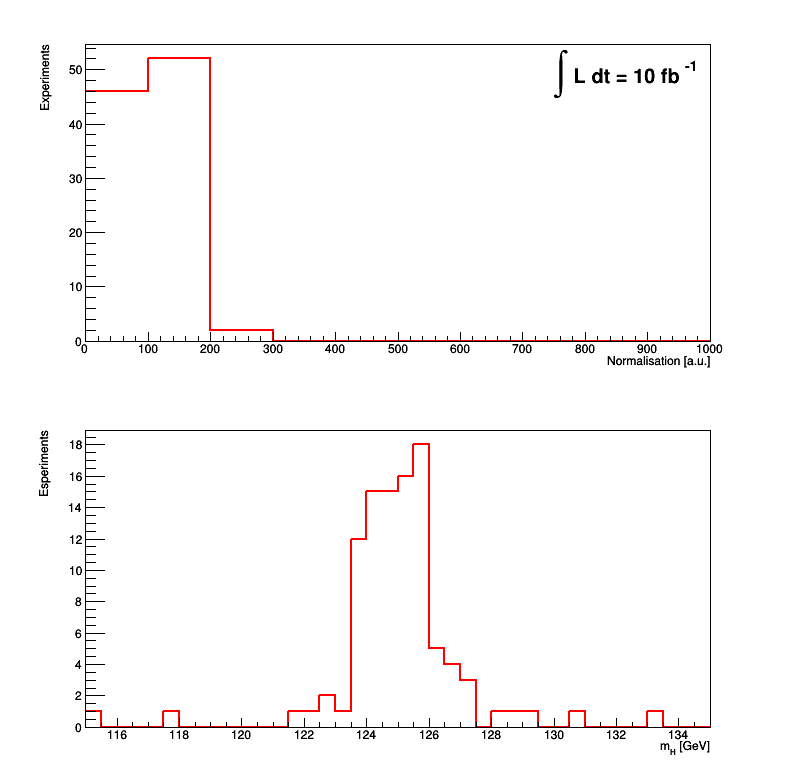

In [11]:
toyplots = ROOT.TCanvas("toyplots","",800,800)
toyplots.Divide(1,2)

toyplots.cd(1)
h_norm.SetStats(0)
h_norm.SetLineColor(2); h_norm.SetLineWidth(2)
h_norm.GetXaxis().SetTitle("Normalisation [a.u.]")
h_norm.GetYaxis().SetTitle("Experiments");
h_norm.Draw()

label.SetTextSize(0.06);
label.SetTextAlign(12);
label.DrawLatexNDC(0.7,0.8,"#int L dt = "+str(int(L))+" fb^{-1}")

toyplots.cd(2);
h_mH.SetStats(0)
h_mH.SetLineColor(2), h_mH.SetLineWidth(2)
h_mH.GetXaxis().SetTitle("m_{H} [GeV]");
h_mH.GetYaxis().SetTitle("Esperiments");
h_mH.Draw();

toyplots.Draw()

# 4. Significance vs. Luminosity

We want now to study the evolution of the expected signal significance as a function of the amuont of collected data. We have (approximatively) defined the signal significance as:

$$ Z \sim \frac{N_S}{\sqrt{N_B}}$$

with

$$p_0 = 1 - \text{Erf}\left( \frac{N_S}{\sqrt{N_B}} \right) $$

In thi exercise we will use a even more approximate definition, using:

$$ Z = \frac{N_S}{\sigma_{N_S}} = \frac{p_2}{\sigma_{p_2}} $$

For each luminosity point we will run a certain number of toy experiments, averaging the observed significances to smooth out the fluctuations.

Try to see what happens if you set the detector resolution be larger or smaller than the default value: how much data do you need to reach 5 $\sigma$?

In [12]:
ntoys  = 100  # number of toy experiments
m_H    = 125. # GeV
s_m    = 1.4  # GeV

nL = 5
L0 = 30.
dL = 20.

sig_vs_L = ROOT.TGraph(nL)
sig_vs_L.SetTitle("")

In [ ]:
for j in range(nL): # loop on luminosity values
    
    # increasing luminosity
    L = L0+dL*j
    print ("*** L = " + str(int(L)) + " fb-1 : running " + str(ntoys) + " toy experiments...")

    signif = 0.
    np = 0

    for i in range(ntoys): # loop on toys
    
        mgg = DataHistogram(m_H,s_m,L)

        massFit.SetParameter(0,L*1000.) 
        massFit.SetParameter(1,0.023)  
        massFit.SetParameter(2,L*10.)   
        massFit.SetParameter(3,m_H)
        massFit.FixParameter(4,s_m) 
        
        #massFit.SetParLimits(3,m_H-10.,m_H+10.)
        massFit.SetParLimits(0,0.,L*10000000.);
        
        mgg.Fit(massFit,"Q")
    
        # compute significance for this toy experiment, sum to average over all toys
        norm  = massFit.GetParameter(2); # gaussian normalization
        snorm = massFit.GetParError(2);  # error on gaussian normalization      
        signif += norm/snorm # poor-man significance :-)
        np = np + 1

    # average significance over toy experiments
    signif/=np;
    sig_vs_L.SetPoint(j,L,signif);

*** L = 30 fb-1 : running 100 toy experiments...
*** L = 50 fb-1 : running 100 toy experiments...
*** L = 70 fb-1 : running 100 toy experiments...
*** L = 90 fb-1 : running 100 toy experiments...
*** L = 110 fb-1 : running 100 toy experiments...


In [ ]:
sigplot_vs_L = ROOT.TCanvas("sigplot_vs_L","",800,400)

sig_vs_L.SetMarkerStyle(20);
sig_vs_L.SetMarkerColor(2);
sig_vs_L.GetXaxis().SetTitle("L [fb^{-1}]");
sig_vs_L.GetYaxis().SetTitle("Significance");
sig_vs_L.Draw("APX");

sigplot_vs_L.Draw()

# 4. Significance vs. Detector resolution

Let's now repeat the previous exercise by fixing the amount of data to 100 fb$^{-1}$, and testing several values for the detector invariant mass resolution.

In [ ]:
ntoys  = 100  # number of toy experiments
m_H    = 125. # GeV
L      = 100  # GeV

nS = 5
S0 = 1.
dS = 0.2

sig_vs_S = ROOT.TGraph(nL)
sig_vs_S.SetTitle("")

In [ ]:
for j in range(nS): # loop on luminosity values
    
    # increasing luminosity
    s_m = S0+dS*j
    print ("*** sigma_yy = " + str(s_m) + " GeV : running " + str(ntoys) + " toy experiments...")

    signif = 0.
    np = 0

    for i in range(ntoys): # loop on toys
    
        mgg = DataHistogram(m_H,s_m,L)

        massFit.SetParameter(0,L*1000.) 
        massFit.SetParameter(1,0.023)  
        massFit.SetParameter(2,L*10.)   
        massFit.SetParameter(3,m_H)
        massFit.FixParameter(4,s_m) 
        
        #massFit.SetParLimits(3,m_H-10.,m_H+10.)
        massFit.SetParLimits(0,0.,L*10000000.);
        
        mgg.Fit(massFit,"Q")
    
        # compute significance for this toy experiment, sum to average over all toys
        norm  = massFit.GetParameter(2); # gaussian normalization
        snorm = massFit.GetParError(2);  # error on gaussian normalization      
        signif += norm/snorm # poor-man significance :-)
        np = np + 1

    # average significance over toy experiments
    signif/=np;
    sig_vs_S.SetPoint(j,s_m,signif);

In [ ]:
sigplot_vs_S = ROOT.TCanvas("sigplot_vs_S","",800,400)

sig_vs_S.SetMarkerStyle(20);
sig_vs_S.SetMarkerColor(2);
sig_vs_S.GetXaxis().SetTitle("#sigma_{#gamma#gamma} [GeV]");
sig_vs_S.GetYaxis().SetTitle("Significance");
sig_vs_S.Draw("APX");

sigplot_vs_L.Draw()